In [1]:
!nvidia-smi

Sat Oct  7 14:55:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 36%   42C    P8     1W /  38W |    396MiB /  2048MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   

In [2]:
# Check CUDA Version
!python -c "import torch; print(torch.version.cuda)"

11.7


## Knowledge Graphs and Node Classification

There are two special properties we are dealing with in this example:
1. We have one large graph and not many individual graphs (like molecules)
2. We infere on unlabeled nodes in this large graph and hence perform node-level predictions --> We have to use different nodes of the graph depending on what we want to do

## Dataset Introduction

There exists different datasets in PyTorch Geometric that can be used to perform Node Classification on large Knowledge Graphs e.g. Karate Network or Cora. We will use Cora to showcase the use of binary masks for node-level predictions.

#### What is the Cora Dataset?
The Cora dataset consists of 2708 scientific publications classified into one of seven classes. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

- Nodes = Publications (Papers, Books ...)
- Edges = Citations
- Node Features = word vectors
- 7 Labels = Pubilcation type e.g. Neural_Networks, Rule_Learning, Reinforcement_Learning, 	Probabilistic_Methods...

We normalize the features using torch geometric's transform functions.

PyTorch Geometric provides different functions to investigate the dataset (e.g. node degrees, self-loops ect.) - You can find more of them in the documentation or in [this notebook](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing#scrollTo=eqWR0j_kIx67).

In [4]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [6]:
dataset = Planetoid(root="../data",name="Cora",transform=NormalizeFeatures())

In [19]:
# Get some basic info about the dataset
print(f"Number of graphs:{len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")
print("-"*50)

# There is only one graph in the dataset, use it as new data object
data = dataset[0]

# Gather same statistics about the graph
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum())/data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs:1
Number of features: 1433
Number of classes: 7
--------------------------------------------------
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True


Observations:
- We only have a relatively small set of training nodes (20 nodes per class)
- There are binary test, train and validation masks of the size #nodes (they tell use which node can be used for which task)

In [22]:
print(data.x.shape) # [No. Nodes x Features]

# Print some of the normalized word counts of the first datapoint
data.x[0][:50]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

Why do we even use the graph structure - aren't the features enough?

- Apparently, simple MLP models perform a lot worse than GNNs on this type of task, as the citation information is crucial for a correct classification

How do the labels look like?
- They are encoded as numeric value between 0-6

In [23]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [25]:
 # Example for the binary masks
print(len(data.test_mask) == data.num_nodes)
data.test_mask

True


tensor([False, False, False,  ...,  True,  True,  True])

In [27]:
# Example for the edge connections
data.edge_index.t()

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

## Graph Neural Network for Node Classification

In [32]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv # GATConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x ,p=0.5, training=self.training)

        # Second message passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output Layer
        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


Observations:
- Dropout is only applied in the training step, but not for predictions
- We have 2 Message Passing Layers and one Linear output layer
- We use the softmax function for the classification problem
- The output of the model are 7 probabilities, one for each class

## Training and Evaluation

In [88]:
# Initialize model
model = GCN(hidden_channels=16)

# USe GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Initialize Optimizer
learning_rate = 0.01
decay = 5e-6
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=decay)

# Define loss function (CrossEntropyLoss for Classification Problems with
# probability distributions)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    # Use all data as input, because all nodes have node features
    out = model(data.x, data.edge_index)
    # Only use nodes with labels available for loss calculation -->mask
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    
    # Use the class with highest probability
    pred = out.argmax(dim=1)
    
    # Check against ground-truth labels
    test_correct = pred[data.test_mask] == data.y[data.test_mask]

    #Derive ratio of correct predictions
    test_acc = int(test_correct.sum())/int(data.test_mask.sum())
    return test_acc

In [89]:
# Training
losses = []
for epoch in range(0,10001):
    loss = train()
    losses.append(loss)
    if epoch % 1000 == 0:
        print(f'Epoch {epoch:03d}, Loss:{loss:.4f}')

Epoch 000, Loss:1.9461
Epoch 1000, Loss:1.2083
Epoch 2000, Loss:1.2089
Epoch 3000, Loss:1.2167
Epoch 4000, Loss:1.2316
Epoch 5000, Loss:1.1824
Epoch 6000, Loss:1.2229
Epoch 7000, Loss:1.1949
Epoch 8000, Loss:1.1986
Epoch 9000, Loss:1.1888
Epoch 10000, Loss:1.2131


## Visualizing the embeddings

In [90]:
import matplotlib.pyplot as plt

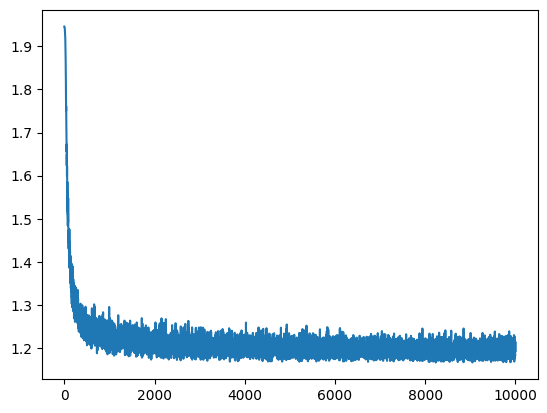

In [91]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
plt.plot(losses_float)

In [92]:
# Calculate test metric
test_acc = test()
print(f'Testing Accuracy: {test_acc:.4f}')

Testing Accuracy: 0.7350


## Visualizing the embeddings

In [59]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.fromstring(rgb_str, dtype=np.uint8, sep='').reshape((w,h,-1))
    return rgba_arr


def visualize(h, color, epoch):
    fig = plt.figure(figsize=(5,5), frameon=False)
    fig.suptitle(f'Epoch = {epoch}')
    # Fit TSNE with 2 components
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    # Create scatterplot from embeddings
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], 
                z[:, 1], 
                s=70, 
                c=color.detach().cpu().numpy(), 
                cmap="Set2")
    fig.canvas.draw()

    # Convert to numpy
    return plt2arr(fig)


# Reset the previously trained model weights
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

TSNE Visualization finished.


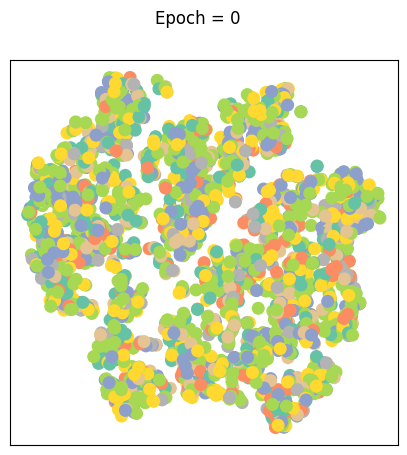

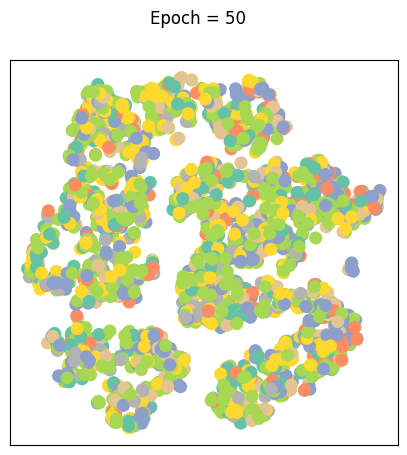

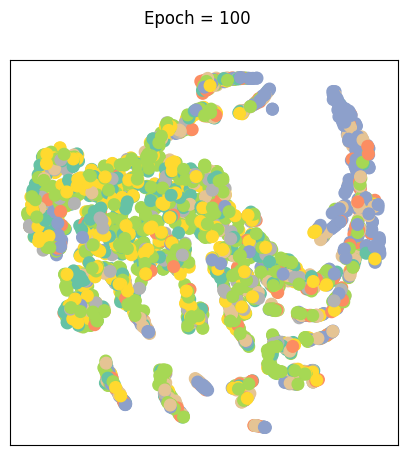

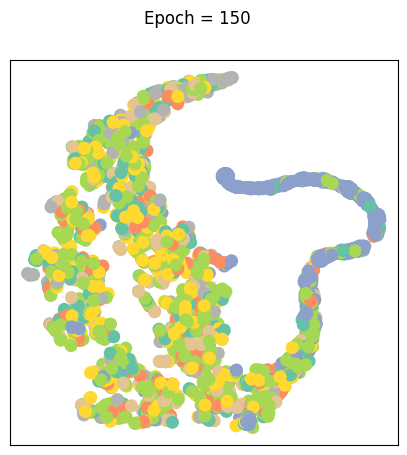

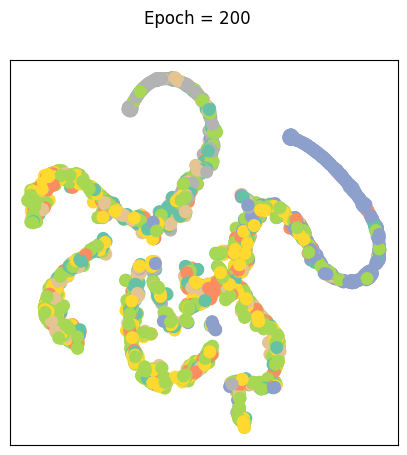

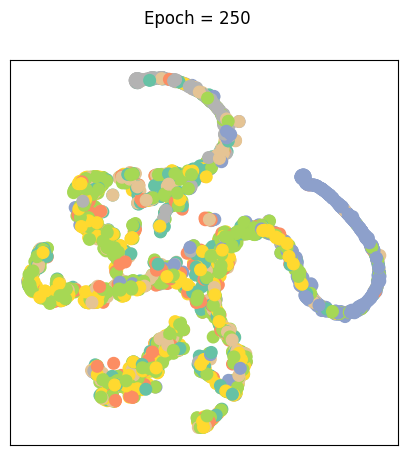

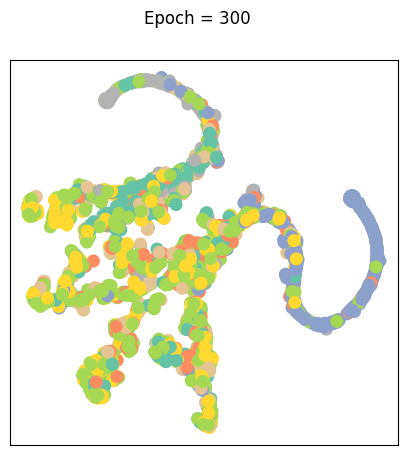

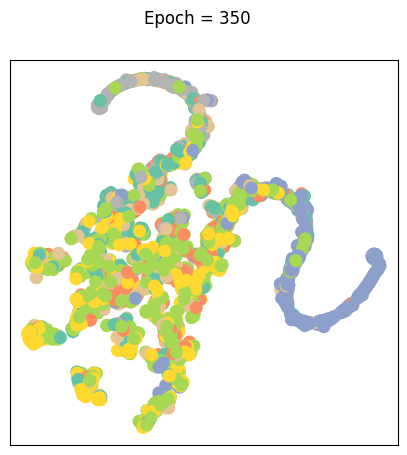

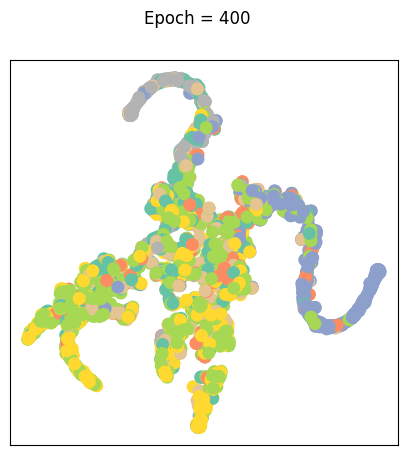

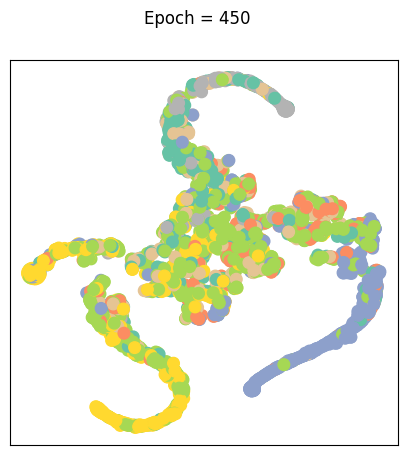

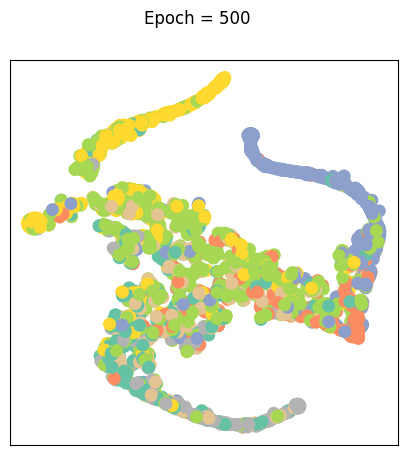

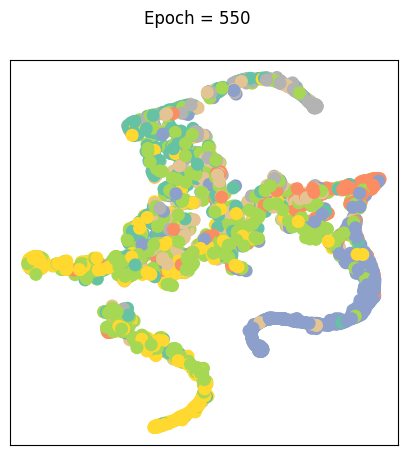

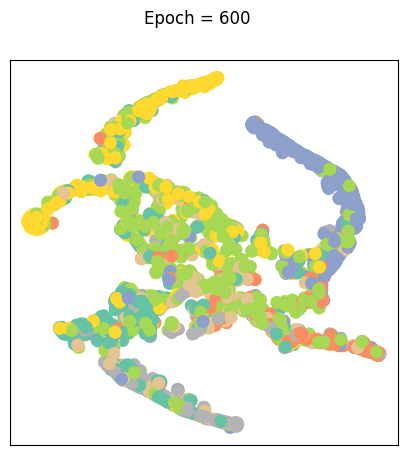

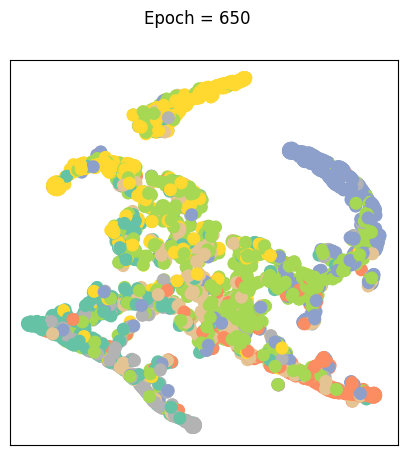

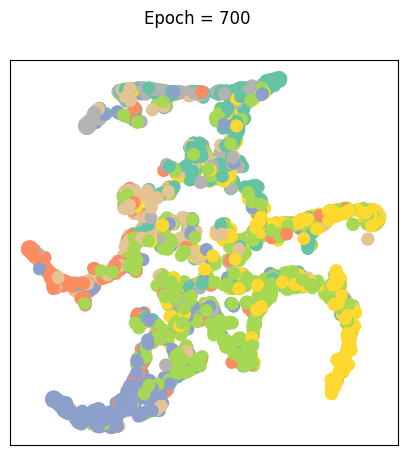

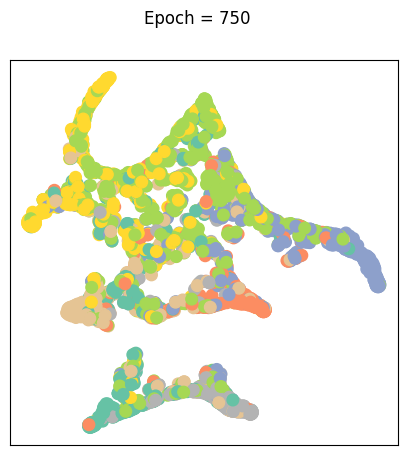

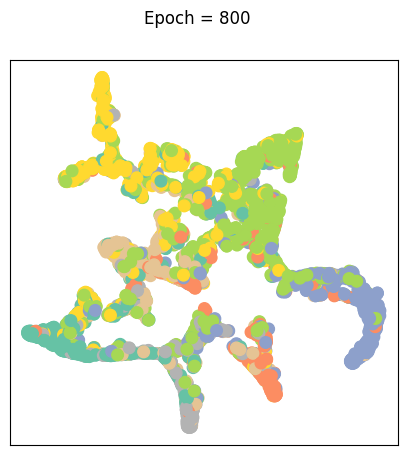

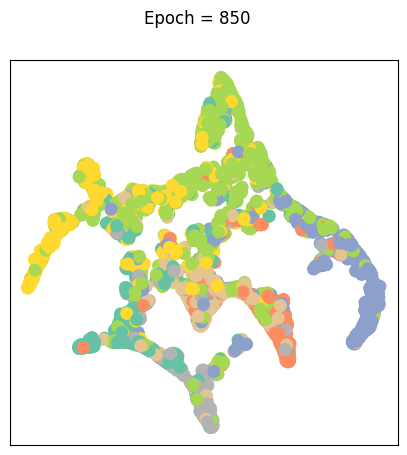

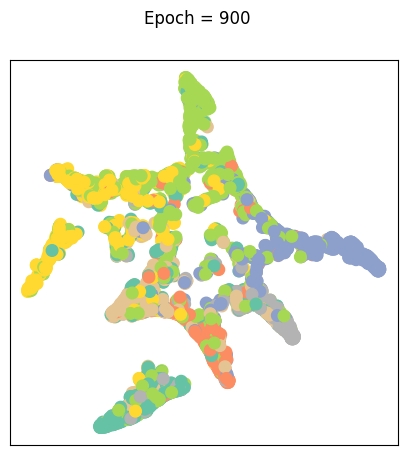

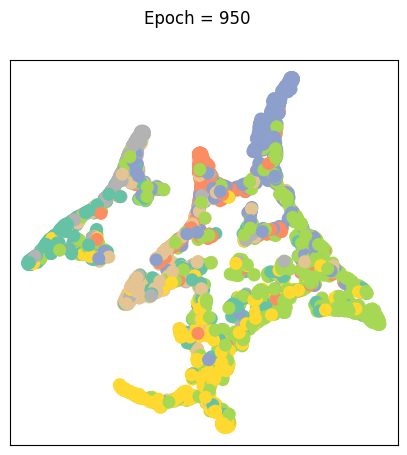

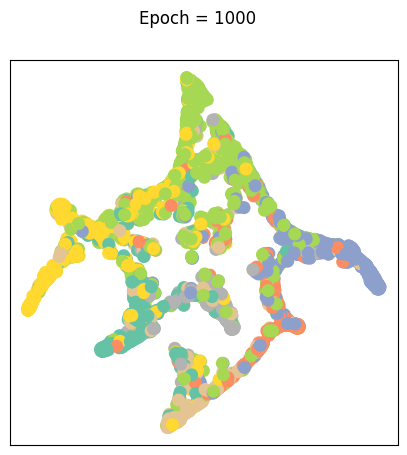

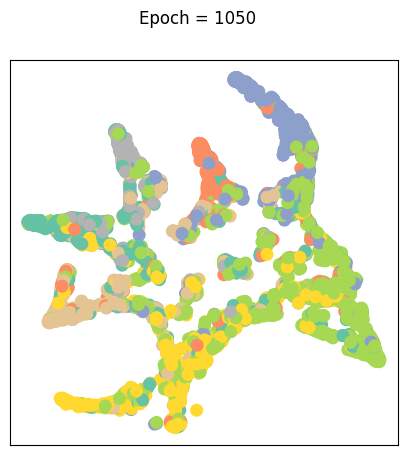

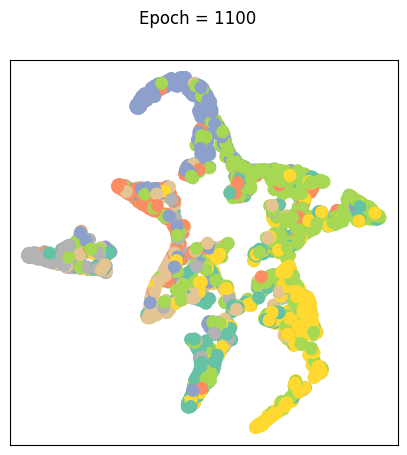

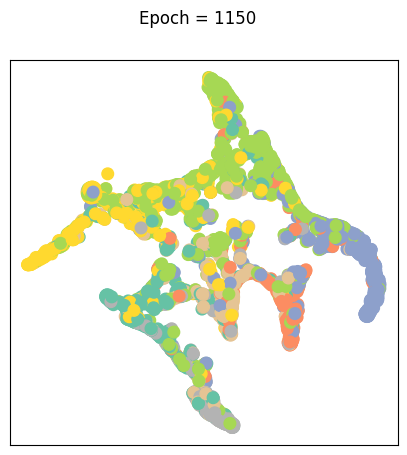

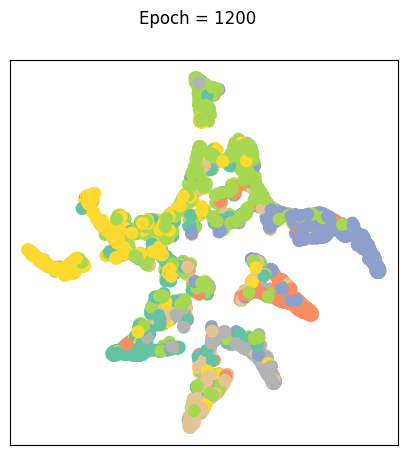

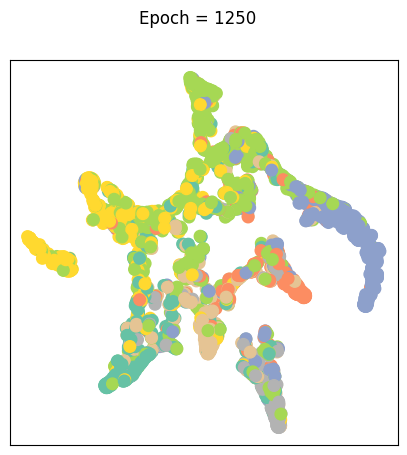

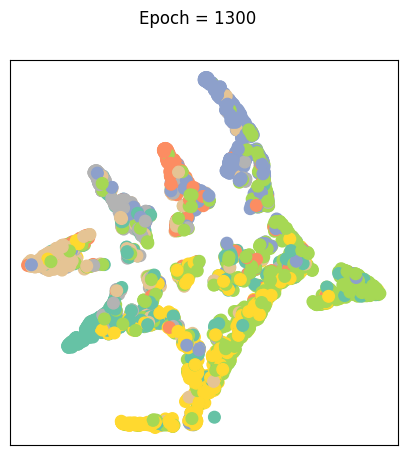

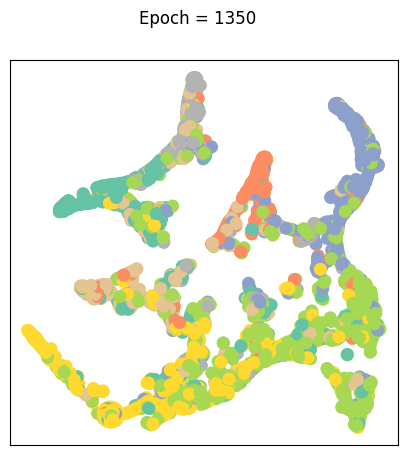

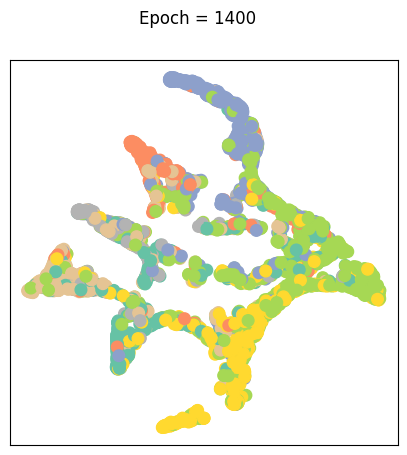

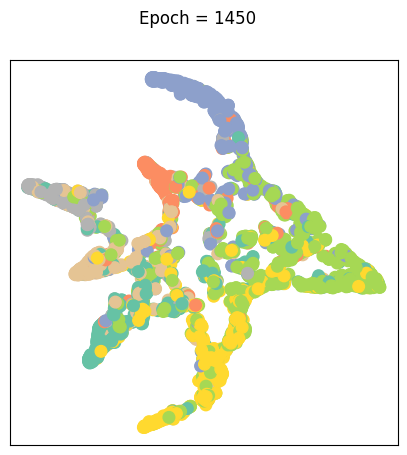

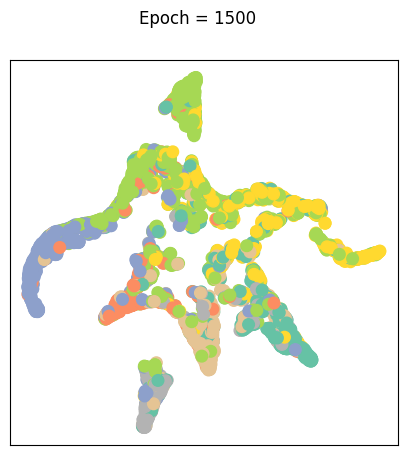

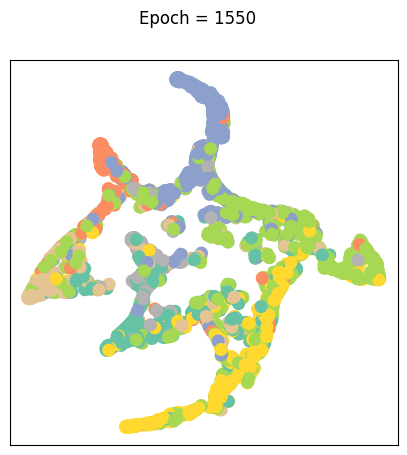

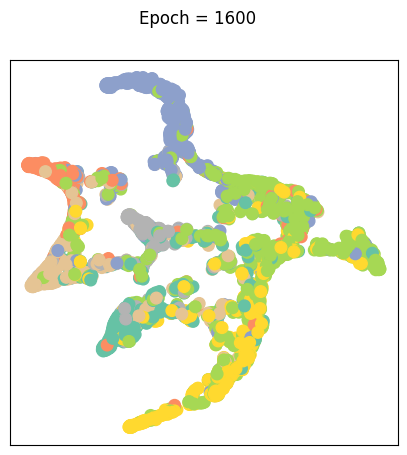

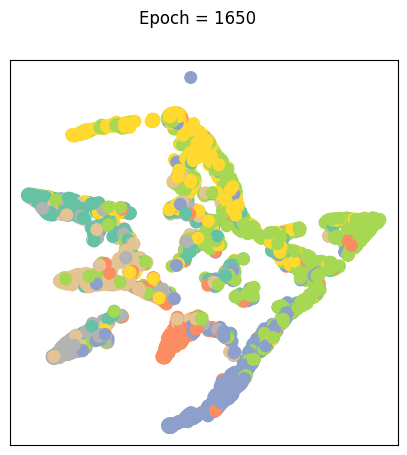

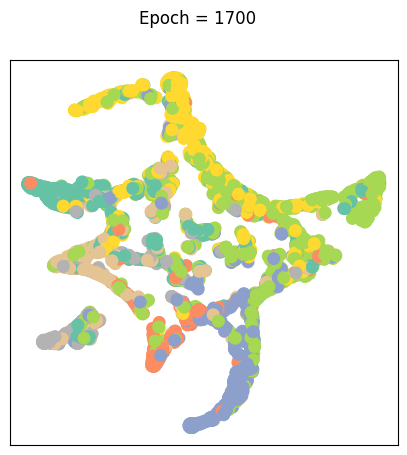

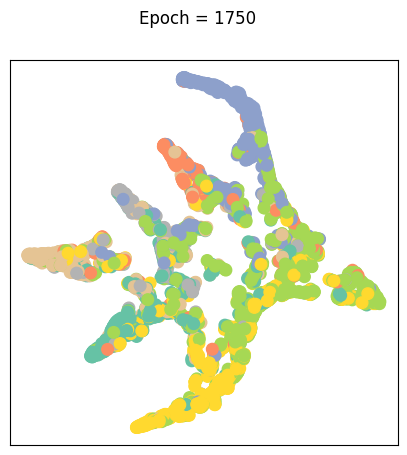

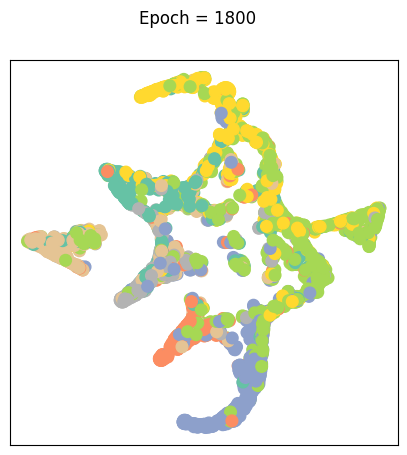

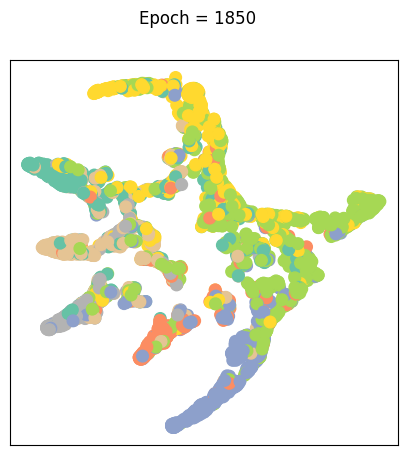

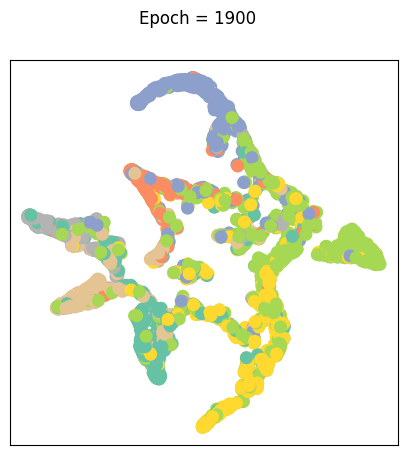

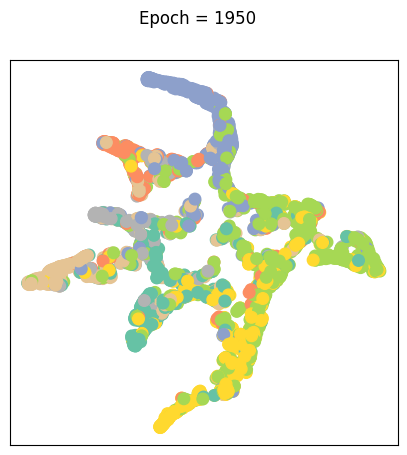

In [60]:
# Ignore deprecation warnings here
import warnings
warnings.filterwarnings('ignore')

# Train the model and save visualizations
images = []
for epoch in range(0, 2000):
    loss = train()
    if epoch % 50 == 0:
      out = model(data.x, data.edge_index)
      images.append(visualize(out, color=data.y, epoch=epoch))
print("TSNE Visualization finished.")

In [61]:
# Build a gif from this
!pip install moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 1.5 MB/s eta 0:00:001.5 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for imageio_ffmpeg>=0.2.0 from https://files.pythonhosted.org/packages/1a/98/3df1d8dd8f2c121b6c588b1e0d604f36592d56df9c41fb155ed546c6a5ed/imageio_ffmpeg-0.4.9-py3-none-manylinux2010_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 712.1 kB/s eta 0:00:00m eta 0:00:010:00:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110721 sha256=63529099ff3aa9d76b615cbb3155b2778a6ffa010af103c8f0f2d2f1dcae1a4e
  Stored in directory: /home/gom/.cache/pip/wheels/e4/a4/db/0368d3a04033da662e13926594b3a8cf1aa4ffeefe570cfac1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


In [64]:
from moviepy.editor import ImageSequenceClip
fps = 1
filename = "embeddings.gif"
clip = ImageSequenceClip(images, fps=fps)
clip.write_gif(filename, fps=fps)

MoviePy - Building file embeddings.gif with imageio.


In [70]:
torch.cuda.empty_cache()

![fig](../assets/embeddings.gif)

## Improving the model
- Cross-Validation
- Hyperparameter Optimization
- Different layer types GCN, GAT... ([here](hhttps://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html))
- Including edge features ([here](https://wiki.tum.de/display/dlma/Exploiting+Edge+Features+in+Graph+Neural+Networks))  
--> The best performance is currently [at around 0.9](https://paperswithcode.com/sota/node-classification-on-cora)